# Оценка релевантности организаций запросам на Яндекс.Картах с помощью LLM-агента

<img src="https://sun9-65.userapi.com/impg/N4y2cxlL7PauAs82tBNFOUAiNctFICWDy4Mbiw/Jiz1fb7NLWU.jpg?size=1080x1080&quality=95&sign=df2786058624d9ccac3ede4d5d056e2f&type=album" width="500" height="500" />


## Описание задачи

Необходимо создать LLM-агента, который будет оценивать релевантность организаций на Яндекс.Картах широким запросам (например, "ресторан с верандой" или "романтичный джаз-бар"). Такие запросы называются *рубричными*: пользователь здесь ищет не конкретную организацию, а идёт в Яндекс.Карты для поиска и выбора мест.

LLM-агент должен будет самостоятельно находить необходимые данные для принятия правильного решения.

Данные представлены компанией Яндекс и являются результатами асессорской разметки релевантности. Мы очень заинтересован в успешном решении задачи:)

## План работы

1. Написать сильный бейзлайн. Например, можно просто делать один запрос в LLM, возможно с добавлением в промпт размеченных примеров. Либо можно дообучить трансформер на задачу классификации.
2. Разобраться с фреймворком для реализации LLM-агентов (предлагается использовать LangGraph, оба примера в доп. материалах используют его).
3. Реализовать первую версию агента: предложить ему не принимать решение мгновенно, а ходить в поисковик для уточнения своего ответа.
4. Поработать над промптами для улучшения качества. Здесь нужно будет посмотреть, в каких запросах агент ошибается. **ПОЖАЛУЙСТА, НЕ ПОДГЛЯДЫВАЙТЕ, КАК ИМЕННО АГЕНТ ОШИБАЕТСЯ НА EVAL-МНОЖЕСТВЕ, ДЛЯ ЭТОГО ЕСТЬ TRAIN**.
5. Другие идеи (опционально):
- с помощью нейросетевого ретривала можно найти в обучающем множестве похожие размеченные примеры
- можно реализовать tool для парсинга сайта, которую агент будет вызывать

## Про платные API

Обратите внимание, что для реализации проекта потребуется самостоятельно ходить в OpenAI API (и другие платные API). На это может уйти существенная сумма (по грубой оценке ментора, 500 запусков агента на стеке OpenAI легко уложатся в 2к рублей, но риски вылезти за эту границу есть. Можно использовать и более дешевые LLM). Также поможет иностранная карта для оплаты этих сервисов, но в целом без нее можно обойтись.

Сам я для запросов в OpenAI API часто использую сервис https://vsegpt.ru/ (не реклама). При их использовании вам не нужен VPN, достаточно российской карты, а цены не сильно отличаются от цен OpenAI, но нужно оплатить подписку (400 рублей).

**О ТОМ, КАКИЕ КЛАССНЫЕ И ДЕШЕВЫЕ АЛЬТЕРНАТИВЫ ВЫ НАШЛИ, ОБЯЗАТЕЛЬНО НАПИШИТЕ В ЧАТ**

## Система оценивания

1. Реализация бейзлайна (без использования агента, но можно с использованием LLM) -- 2 балла
2. Реализация "какого-то" агента, который под капотом имеет возможность обращаться к поисковой строке для уточнения результата -- 4 балла
3. Существенно побить бейзлайн или безуспешно приложить к этому усилия и "показать", что агенты в этой задаче прироста не дают -- 4 балла
4. (опционально, за шоколадку) реализовать одну из доп. идей по улучшению агента

## Что почитать/посмотреть по теме

1. Статья, по которой можно составить какое-то представление об агенте -- https://habr.com/ru/articles/864646/
2. https://www.youtube.com/watch?v=U6LbW2IFUQw -- неплохое видео, где на практике подробно расписано, как агента можно создавать
3. Придётся самим много читать и разбираться. Делитесь идеями в чате:)

## Описание и загрузка данных

Данные: https://disk.yandex.ru/d/6d5hFHvpAZjQdw

Ваша задача -- предсказать колонку relevance, используя все остальные данные об организации. Загрузим данные и посмотрим на них

In [2]:
import pandas as pd

data = pd.read_json(path_or_buf="./content/data_final_for_dls_new.jsonl", lines=True)
data.rename(columns= {"relevance": "relevance_old", "relevance_new": "relevance"}, inplace=True)
data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance_old,reviews_summarized,relevance
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,None,1.0,"Организация занимается продажей табака, курите...",1.0
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0.0
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1.0
3,спортзал где 1 занятие бесплатно,"Москва, Страстной бульвар, 13А",Унца Унца Спорт; Unza Unza Sport,Фитнес-клуб,201938477844,Фитнес-клуб предлагает пробные занятия по разл...,0.1,Организация «Унца Унца Спорт» предоставляет ус...,0.1
4,стиральных машин,"Москва, улица Обручева, 34/63",М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,1074529324,М.Видео предлагает широкий ассортимент бытовой...,1.0,Организация занимается продажей бытовой техник...,1.0
...,...,...,...,...,...,...,...,...,...
35089,нотариус запись,"Москва, 15-я Парковая улица, 45",Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,1056199530,None,1.0,Организация предоставляет нотариальные услуги ...,1.0
35090,стационар для кота москва,"Москва, улица Госпитальный Вал, 3, корп. 5",ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,133156701339,"Ветеринарная клиника, аптека и лаборатория «Тр...",0.0,"Организация занимается ветеринарными услугами,...",0.0
35091,агзс пропан,"Самара, улица 22-го Партсъезда, 49, корп. 1",Роза Мира; АЗС № 2; Роза мира,АЗС,6884296946,None,0.0,Организация занимается заправкой транспортных ...,0.0
35092,где вибрить ваз 2112,"Нижний Новгород, Московское шоссе, 34","Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,124836381099,Автосалон «Нижегородец» предлагает новые автом...,0.0,Автосалон «Нижегородец» занимается продажей и ...,0.0


In [3]:
data['relevance'].value_counts()

relevance
1.0    15950
0.0    14441
0.1     4703
Name: count, dtype: int64

Здесь 1.0 соответствует оценке RELEVANT_PLUS, 0.1 -- оценке RELEVANT_MINUS, 0.0 -- оценке IRRELEVANT.

Ваша задача -- построить LLM-агента, который будет предсказывать релевантность.

Выделим данные для оценки качества агента. Запуск агента -- это тяжелая и потенциально дорогая операция. Поэтому eval-множество имеет размер 500. Также для простоты из eval-множества выкинуты данные с оценкой RELEVANT_MINUS. Тем не менее, вы можете использовать такие примеры для подачи примеров агенту.

**ОБРАТИТЕ ВНИМАНИЕ, ЧТО В EVAL-ДАННЫЕ НЕЛЬЗЯ ПОДГЛЯДЫВАТЬ ДЛЯ КАЛИБРОВКИ АГЕНТА!!! ДЛЯ ЭТОГО ЕСТЬ ОБУЧАЮЩИЕ ДАННЫЕ**

В качестве метрики качества мы будем использовать обычную ACCURACY, поскольку классы сбалансированы.

In [4]:
train_data = data[570:]
train_data = train_data[train_data['relevance'] != 0.1] # добавим фильтр для консистентности трейна и теста

eval_data = data[:570]
eval_data = eval_data[eval_data["relevance"] != 0.1]
eval_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance_old,reviews_summarized,relevance
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,None,1.0,"Организация занимается продажей табака, курите...",1.0
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0.0
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1.0
4,стиральных машин,"Москва, улица Обручева, 34/63",М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,1074529324,М.Видео предлагает широкий ассортимент бытовой...,1.0,Организация занимается продажей бытовой техник...,1.0
5,сеть быстрого питания,"Санкт-Петербург, 1-я Красноармейская улица, 15",Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,1219173871,Rostic's предлагает различные наборы быстрого ...,1.0,"Организация занимается быстрым питанием, предо...",1.0
...,...,...,...,...,...,...,...,...,...
561,наращивание ресниц,"Саратов, улица имени А.С. Пушкина, 1",Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,236976975812,Салон красоты «Сила» предлагает услуги по уход...,1.0,Организация «Сила» занимается предоставлением ...,1.0
565,игры,"Москва, Щёлковское шоссе, 79, корп. 1",YouPlay; YouPlay КиберКлуб,Компьютерный клуб,109673025161,YouPlay КиберКлуб предлагает услуги по игре на...,0.0,Организация занимается предоставлением услуг к...,0.0
566,домашний интернет в курске что подключить отзы...,"Курск, Садовая улица, 5",Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,1737991898,None,0.0,None,0.0
567,гостиница волгодонск сауна номер телефона,"Ростовская область, городской округ Волгодонск...",Поплавок; Poplavok,"База , дом отдыха",147783493467,"Предлагает размещение в различных типах жилья,...",0.0,Организация «Поплавок» предлагает услуги базы ...,0.0


In [5]:
train_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance_old,reviews_summarized,relevance
570,налоговая 5007,"Московская область, Королёв, улица Богомолова, 4",Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,1377658436,None,0.0,Организация занимается обслуживанием налогопла...,0.0
571,шугаринг Красноярск,"Красноярск, микрорайон Взлётка, улица Весны, 3",Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,1085001465,Студия красоты «Дарлинг» предоставляет услуги ...,1.0,Студия красоты «Дарлинг» предоставляет бьюти-у...,1.0
573,новогодняя ночь 2018 в ресторане,"Москва, Кутузовский проспект, 36А",Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,1187477091,Ресторан Atlantica предлагает разнообразные бл...,1.0,Организация занимается ресторанным бизнесом и ...,1.0
574,балетная школа в санкт петербурге 12лет с прож...,"Санкт-Петербург, Невский проспект, 35В",Русская национальная балетная школа Илзе Лиепа...,Школа танцев,172170646460,None,0.0,Организация занимается обучением балету и хоре...,0.0
575,солкосерил гель цена,"Москва, Симферопольский бульвар, 29, корп. 1",Столички; Stolichki; Apteki Stolichki,Аптека,226500195223,Аптека «Столички» предлагает широкий спектр ле...,1.0,Организация занимается продажей лекарств и мед...,1.0
...,...,...,...,...,...,...,...,...,...
35089,нотариус запись,"Москва, 15-я Парковая улица, 45",Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,1056199530,None,1.0,Организация предоставляет нотариальные услуги ...,1.0
35090,стационар для кота москва,"Москва, улица Госпитальный Вал, 3, корп. 5",ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,133156701339,"Ветеринарная клиника, аптека и лаборатория «Тр...",0.0,"Организация занимается ветеринарными услугами,...",0.0
35091,агзс пропан,"Самара, улица 22-го Партсъезда, 49, корп. 1",Роза Мира; АЗС № 2; Роза мира,АЗС,6884296946,None,0.0,Организация занимается заправкой транспортных ...,0.0
35092,где вибрить ваз 2112,"Нижний Новгород, Московское шоссе, 34","Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,124836381099,Автосалон «Нижегородец» предлагает новые автом...,0.0,Автосалон «Нижегородец» занимается продажей и ...,0.0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29891 entries, 570 to 35093
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Text                            29891 non-null  object 
 1   address                         29891 non-null  object 
 2   name                            29891 non-null  object 
 3   normalized_main_rubric_name_ru  29891 non-null  object 
 4   permalink                       29891 non-null  int64  
 5   prices_summarized               17659 non-null  object 
 6   relevance_old                   29891 non-null  float64
 7   reviews_summarized              28688 non-null  object 
 8   relevance                       29891 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 2.3+ MB


In [7]:
%load_ext autoreload
%autoreload 2
# перезагружать локальные модули, если они меняются (иначе придется перезагружать ядро)

sys.path.append('../../../')
from llm_secrets import *
from copy import deepcopy
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from typing import List, Dict
import json
import requests
import faiss
from sklearn.metrics.pairwise import cosine_similarity
from datetime import timedelta
import requests_cache  # КЭШИРУЕМ ЗАПРОСЫ ЧЕРЕЗ requests!
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import tqdm

class YaClient():
    def __init__(self):
        # super().__init__()
        pass    

    def encode_basic(self, texts: List[str], model_uri_tag: str, normalize: bool=False) -> List:
        # в отличие от гигачата и OS-моделей, яндекс не принимает батчи, поэтому нет смысла отправлять в тот метод >1 примера
        url = "https://llm.api.cloud.yandex.net/foundationModels/v1/textEmbedding"
        embeddings = []
        for text in texts:
            payload = json.dumps({
            "modelUri": "emb://" + YA_DEV_CENS_FOLDER_ID + "/" + model_uri_tag,
            "text": text
            })
            headers = {
            'Authorization': 'Api-Key ' + YA_DEV_CENS_API_KEY,
            'x-folder-id': YA_DEV_CENS_FOLDER_ID,
            'Content-Type': 'application/json'
            }

            response = requests.request("POST", url, headers=headers, data=payload, verify=False)

            response_json = response.json()
            if response.status_code !=200:
                raise Exception('Код ответа ' + str(response.status_code))
            embeddings.append(response_json['embedding'])
        if normalize:
            embeddings = np.array(embeddings).astype('float32')
            faiss.normalize_L2( embeddings ) # inplace, returns None!
        return embeddings

    def encode_queries(self, texts: List[str], normalize: bool=False) -> List:
        return self.encode_basic(texts, model_uri_tag='text-search-query/latest', normalize=normalize)

    def encode_documents(self, texts: List[str], normalize: bool=False) -> List:
        return self.encode_basic(texts, model_uri_tag='text-search-doc/latest', normalize=normalize)
    
    def get_cosine_similarity(self, query_text: str, document_text: str) -> float:
        query_embeddings = self.encode_queries([query_text], normalize=True)
        document_embeddings = self.encode_documents([document_text], normalize=True)
        # distance = cosine_similarity(question_embeddings[np.newaxis,:], candidate_embeddings[np.newaxis,:])
        distance = cosine_similarity(query_embeddings, document_embeddings)[0][0]
        return distance
    
    
def enable_http_requests_cache():
    requests_cache.install_cache(cache_name='./http_cache', backend='sqlite', serializer=None,
                                 expire_after=timedelta(days=180), urls_expire_after=None, cache_control=False,
                                 allowable_codes=(200, 204), allowable_methods=('GET', 'POST', 'HEAD'),
                                 always_revalidate=False,
                                 ignored_parameters=(
                                     'Authorization', 'X-API-KEY', 'access_token', 'api_key', 'x-folder-id', 'JWT',
                                     'cookie', 'created'), match_headers=False, filter_fn=None, key_fn=None,
                                 stale_if_error=False)
    # requests_cache.install_cache(cache_name='./http_cache', backend='filesystem', serializer=None, expire_after=timedelta(days=180), urls_expire_after=None, cache_control=False, allowable_codes=(200,204), allowable_methods=('GET', 'POST', 'HEAD'), always_revalidate=False, 
    #                             ignored_parameters=('Authorization', 'X-API-KEY', 'access_token', 'api_key', 'x-folder-id', 'JWT','cookie', 'created'), match_headers=False, filter_fn=None, key_fn=None, stale_if_error=False)

    # (cache_name='http_cache', backend=None, serializer=None, expire_after=-1, urls_expire_after=None, cache_control=False, allowable_codes=(200,), allowable_methods=('GET', 'HEAD'), always_revalidate=False, ignored_parameters=('Authorization', 'X-API-KEY', 'access_token', 'api_key'), match_headers=False, filter_fn=None, key_fn=None, stale_if_error=False, **kwargs)
    print('requests_cache enabled')

enable_http_requests_cache()

requests_cache enabled


In [8]:
train_data.columns

Index(['Text', 'address', 'name', 'normalized_main_rubric_name_ru',
       'permalink', 'prices_summarized', 'relevance_old', 'reviews_summarized',
       'relevance'],
      dtype='object')

In [9]:
USE_PRICES_SUMMARIZED = True
USE_REVIEWS_SUMMARIZED = False
TRAIN_DATA_PART_SIZE = 18300 # обучаемся не на всем трейне, а на его части
VALID_DATA_SIZE = 500

ya_client = YaClient()
def add_columns(df):
    df['llm_description'] = pd.NA
    df['score'] = pd.NA
    df['text_embeddings'] = pd.NA
    df['llm_description_embeddings'] = pd.NA
    df['concat_embeddings'] = pd.NA

def fill_embeddings(df):
    for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
        text_embeddings = ya_client.encode_queries([row['Text']], normalize=True)[0]
        df.at[i,'text_embeddings'] = text_embeddings
        
        llm_description_embeddings = ya_client.encode_documents([row['llm_description']], normalize=True)[0]
        df.at[i,'llm_description_embeddings'] = llm_description_embeddings
        
        concat_embeddings = np.concat([text_embeddings, llm_description_embeddings])
        df.at[i,'concat_embeddings'] = concat_embeddings
        
def fill_llm_description(df):
    for i, row in df.iterrows():
        llm_description= '# Тип: ' + row['normalized_main_rubric_name_ru'] + '\n\n# Название: ' + row['name'] + '\n\n# Адрес: ' + row['address']
        if USE_PRICES_SUMMARIZED and row['prices_summarized'] != None:
            llm_description += '\n\n# Описание: ' + row['prices_summarized']
        if USE_REVIEWS_SUMMARIZED and row['reviews_summarized'] != None:
            llm_description += '\n\n# Отзывы: ' + row['reviews_summarized']

        df.at[i,'llm_description'] = llm_description
            
    
    # df['llm_description'] = '# Тип: ' + df['normalized_main_rubric_name_ru'] + '\n\n# Название: ' + df['name'] + '\n\n# Адрес: ' + df['address'] + df['name'] + '\n\n# Описание: ' + df['prices_summarized']      
    
def fill_score(df):
    for i, row in df.iterrows():
        df.at[i,'score'] = cosine_similarity([row['text_embeddings']], [row['llm_description_embeddings']])[0][0]


In [10]:
add_columns(train_data)

In [11]:
fill_llm_description(train_data)
train_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance_old,reviews_summarized,relevance,llm_description,score,text_embeddings,llm_description_embeddings,concat_embeddings
570,налоговая 5007,"Московская область, Королёв, улица Богомолова, 4",Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,1377658436,None,0.0,Организация занимается обслуживанием налогопла...,0.0,# Тип: Налоговая инспекция\n\n# Название: Нало...,<NA>,<NA>,<NA>,<NA>
571,шугаринг Красноярск,"Красноярск, микрорайон Взлётка, улица Весны, 3",Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,1085001465,Студия красоты «Дарлинг» предоставляет услуги ...,1.0,Студия красоты «Дарлинг» предоставляет бьюти-у...,1.0,# Тип: Салон красоты\n\n# Название: Студия кра...,<NA>,<NA>,<NA>,<NA>
573,новогодняя ночь 2018 в ресторане,"Москва, Кутузовский проспект, 36А",Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,1187477091,Ресторан Atlantica предлагает разнообразные бл...,1.0,Организация занимается ресторанным бизнесом и ...,1.0,# Тип: Ресторан\n\n# Название: Atlantica seafo...,<NA>,<NA>,<NA>,<NA>
574,балетная школа в санкт петербурге 12лет с прож...,"Санкт-Петербург, Невский проспект, 35В",Русская национальная балетная школа Илзе Лиепа...,Школа танцев,172170646460,None,0.0,Организация занимается обучением балету и хоре...,0.0,# Тип: Школа танцев\n\n# Название: Русская нац...,<NA>,<NA>,<NA>,<NA>
575,солкосерил гель цена,"Москва, Симферопольский бульвар, 29, корп. 1",Столички; Stolichki; Apteki Stolichki,Аптека,226500195223,Аптека «Столички» предлагает широкий спектр ле...,1.0,Организация занимается продажей лекарств и мед...,1.0,# Тип: Аптека\n\n# Название: Столички; Stolich...,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35089,нотариус запись,"Москва, 15-я Парковая улица, 45",Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,1056199530,None,1.0,Организация предоставляет нотариальные услуги ...,1.0,# Тип: Нотариусы\n\n# Название: Нотариус О. Н....,<NA>,<NA>,<NA>,<NA>
35090,стационар для кота москва,"Москва, улица Госпитальный Вал, 3, корп. 5",ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,133156701339,"Ветеринарная клиника, аптека и лаборатория «Тр...",0.0,"Организация занимается ветеринарными услугами,...",0.0,# Тип: Ветеринарная клиника\n\n# Название: Три...,<NA>,<NA>,<NA>,<NA>
35091,агзс пропан,"Самара, улица 22-го Партсъезда, 49, корп. 1",Роза Мира; АЗС № 2; Роза мира,АЗС,6884296946,None,0.0,Организация занимается заправкой транспортных ...,0.0,# Тип: АЗС\n\n# Название: Роза Мира; АЗС № 2; ...,<NA>,<NA>,<NA>,<NA>
35092,где вибрить ваз 2112,"Нижний Новгород, Московское шоссе, 34","Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,124836381099,Автосалон «Нижегородец» предлагает новые автом...,0.0,Автосалон «Нижегородец» занимается продажей и ...,0.0,"# Тип: Автосалон\n\n# Название: Нижегородец, L...",<NA>,<NA>,<NA>,<NA>


In [12]:
train_data_part = deepcopy(train_data[0:TRAIN_DATA_PART_SIZE]).reset_index(drop=True)
train_data_part.relevance.value_counts()

relevance
1.0    9622
0.0    8678
Name: count, dtype: int64

In [13]:
valid_data = deepcopy(train_data[TRAIN_DATA_PART_SIZE+1:TRAIN_DATA_PART_SIZE+1+VALID_DATA_SIZE]).reset_index(drop=True)
valid_data.relevance.value_counts()

relevance
1.0    266
0.0    234
Name: count, dtype: int64

In [14]:
fill_embeddings(train_data_part)
fill_score(train_data_part)
train_data_part

100%|██████████| 18300/18300 [00:49<00:00, 366.73it/s]


,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance_old,reviews_summarized,relevance,llm_description,score,text_embeddings,llm_description_embeddings,concat_embeddings
0,налоговая 5007,"Московская область, Королёв, улица Богомолова, 4",Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,1377658436,None,0.0,Организация занимается обслуживанием налогопла...,0.0,# Тип: Налоговая инспекция\n\n# Название: Нало...,0.483163,"[-0.03561085, 0.0011185607, -0.040828895, 0.01...","[0.0077159125, -0.02134367, 0.021145338, -0.00...","[-0.03561085, 0.0011185607, -0.040828895, 0.01..."
1,шугаринг Красноярск,"Красноярск, микрорайон Взлётка, улица Весны, 3",Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,1085001465,Студия красоты «Дарлинг» предоставляет услуги ...,1.0,Студия красоты «Дарлинг» предоставляет бьюти-у...,1.0,# Тип: Салон красоты\n\n# Название: Студия кра...,0.415885,"[-0.008521172, -0.04705335, 0.10710587, 0.0814...","[-0.00903386, -0.026720082, 0.08441776, 0.0902...","[-0.008521172, -0.04705335, 0.10710587, 0.0814..."
2,новогодняя ночь 2018 в ресторане,"Москва, Кутузовский проспект, 36А",Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,1187477091,Ресторан Atlantica предлагает разнообразные бл...,1.0,Организация занимается ресторанным бизнесом и ...,1.0,# Тип: Ресторан\n\n# Название: Atlantica seafo...,0.228538,"[-0.031984244, 0.001240801, -0.109625384, -0.0...","[0.055363692, 0.022127165, 0.06848739, -0.0535...","[-0.031984244, 0.001240801, -0.109625384, -0.0..."
3,балетная школа в санкт петербурге 12лет с прож...,"Санкт-Петербург, Невский проспект, 35В",Русская национальная балетная школа Илзе Лиепа...,Школа танцев,172170646460,None,0.0,Организация занимается обучением балету и хоре...,0.0,# Тип: Школа танцев\n\n# Название: Русская нац...,0.491791,"[-0.06390377, -0.11706536, 0.12573235, -0.0037...","[-0.030896666, -0.12499036, 0.081109464, 0.006...","[-0.06390377, -0.11706536, 0.12573235, -0.0037..."
4,солкосерил гель цена,"Москва, Симферопольский бульвар, 29, корп. 1",Столички; Stolichki; Apteki Stolichki,Аптека,226500195223,Аптека «Столички» предлагает широкий спектр ле...,1.0,Организация занимается продажей лекарств и мед...,1.0,# Тип: Аптека\n\n# Название: Столички; Stolich...,0.28774,"[-0.07019666, 0.035891853, 0.037936714, 0.0065...","[0.019764189, 0.025319528, 0.06532102, 0.07551...","[-0.07019666, 0.035891853, 0.037936714, 0.0065..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18295,суши в спб рестораны,"Санкт-Петербург, Большая Морская улица, 13",Евразия; Evrasia; Японская кухня; Yaponskaya K...,Ресторан,1013502448,Ресторан «Евразия» предлагает широкий выбор су...,0.0,Организация занимается предоставлением услуг в...,0.0,# Тип: Ресторан\n\n# Название: Евразия; Evrasi...,0.462068,"[0.031038128, -0.021134615, 0.055392526, -0.04...","[0.0608565, 0.0038321435, 0.06451888, -0.04950...","[0.031038128, -0.021134615, 0.055392526, -0.04..."
18296,школьную форму купить,"Санкт-Петербург, Малая Пушкарская улица, 5",Вотоня; ВотОнЯ; ВотОнЯ Воскова; Votonia,Детский магазин,1247245964,"Магазин предлагает детские товары, включая кос...",0.0,Организация «Вотоня» занимается продажей детск...,0.0,# Тип: Детский магазин\n\n# Название: Вотоня; ...,0.252511,"[-0.11260369, -0.026670901, 0.077815555, 0.001...","[0.020921586, -0.06140661, -0.012879517, 0.048...","[-0.11260369, -0.026670901, 0.077815555, 0.001..."
18297,кафе в бутово 24 часа,"Москва, бульвар Адмирала Ушакова, вл1с1",Чайхана Хан Плов; Choyxona Xan Plov; Хан Плов 24,Кафе,76278423376,Чайхана «Хан Плов» предлагает разнообразные бл...,0.0,"Чайхана «Хан Плов» — кафе, где готовят блюда у...",0.0,# Тип: Кафе\n\n# Название: Чайхана Хан Плов; C...,0.364939,"[-0.0076802927, 0.045723114, 0.06599023, -0.10...","[-0.03806253, -0.022098856, -0.039771836, -0.1...","[-0.0076802927, 0.045723114, 0.06599023, -0.10..."
18298,где дешево поесть в домодедово аэропорту 2017,"Московская область, городской округ Домодедо

In [15]:
train_data_part.score = train_data_part.score.fillna(0)
train_data_part.score = train_data_part.score.astype('float')

In [16]:
train_data_part.score.describe()

count    18300.000000
mean         0.370351
std          0.098555
min         -0.194469
25%          0.312582
50%          0.383089
75%          0.439780
max          0.645477
Name: score, dtype: float64

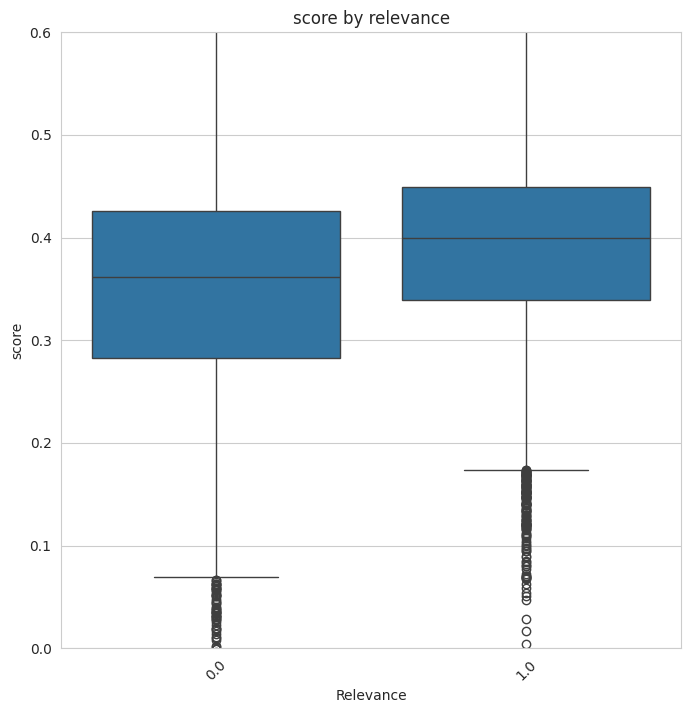

In [17]:
df = train_data_part
plt.figure(figsize=(8, 8))
palette = None#{}
sns.boxplot(x="relevance", y="score", data=df, palette=palette)
plt.title("score by relevance")
plt.xlabel("Relevance")
plt.ylabel("score")
plt.ylim(0, 0.6)
plt.tick_params(axis="x", rotation=45)
plt.show()

In [18]:
def find_best_threshold(df, metrics):
    scores = df["score"]
    labels = df["relevance"]
    thresholds = scores.drop_duplicates().sort_values(ascending=True)
    
    best_threshold = None
    best_metrics = 0
    
    for threshold in thresholds:
        preds = (scores > threshold).astype(int)
        metrics_value = metrics(labels, preds)
        if metrics_value > best_metrics:
            best_metrics = metrics_value
            best_threshold = threshold
    
    print(f"Best threshold: {best_threshold}, Train metrics: {best_metrics:.3f}")
    return best_threshold, best_metrics

In [19]:
best_threshold_f1, best_train_f1 = find_best_threshold(train_data_part, f1_score)

Best threshold: 0.20771446824073792, Train metrics: 0.697


In [20]:
best_threshold_accuracy, best_train_accuracy = find_best_threshold(train_data_part, accuracy_score)
threshold = best_threshold_accuracy

Best threshold: 0.3180427551269531, Train metrics: 0.593


In [21]:
add_columns(valid_data)
fill_llm_description(valid_data)
valid_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance_old,reviews_summarized,relevance,llm_description,score,text_embeddings,llm_description_embeddings,concat_embeddings
0,военные санатории мо рф в 2020 году для военны...,"Республика Крым, Саки, Курортная улица, 2",Сакский военный клинический санаторий им. Н.И....,Санаторий,1375954200,Санаторий предлагает проживание и санаторно-ку...,0.0,Организация занимается предоставлением санатор...,0.0,# Тип: Санаторий\n\n# Название: Сакский военны...,<NA>,<NA>,<NA>,<NA>
1,ремонт радиостанций в красноярске,"Красноярск, улица Партизана Железняка, 40А",Love Radio,Радиокомпания,1106441346,None,0.0,"Организация занимается радиовещанием, транслир...",0.0,# Тип: Радиокомпания\n\n# Название: Love Radio...,<NA>,<NA>,<NA>,<NA>
2,нижневартовск анализы на дому,"Ханты-Мансийский автономный округ — Югра, Нижн...",Медицинский Диагностический центр; Nizhnevarto...,Диагностический центр,1273545737,None,0.0,Медицинский диагностический центр оказывает ме...,0.0,# Тип: Диагностический центр\n\n# Название: Ме...,<NA>,<NA>,<NA>,<NA>
3,детская одежда спб,"Санкт-Петербург, Парфёновская улица, 9к1",ВотОнЯ; Votonya; Вотоня; Votonia,Детский магазин,113200259176,Детский магазин «ВотОнЯ» предлагает товары для...,0.0,Организация занимается продажей детских товаро...,0.0,# Тип: Детский магазин\n\n# Название: ВотОнЯ; ...,<NA>,<NA>,<NA>,<NA>
4,кафе екатеринбурга недорого,"Свердловская область, Екатеринбург, проспект А...",Своя компания; Svoia kompaniia; Svoya kompaniy...,Ресторан,75173646338,Ресторан «Своя компания» предлагает широкий вы...,1.0,"Организация занимается ресторанным бизнесом, п...",1.0,# Тип: Ресторан\n\n# Название: Своя компания; ...,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,детская одежда спб,"Санкт-Петербург, Петергофское шоссе, 51",Beba Kids,Магазин детской одежды,233938357685,"Магазин детской одежды и обуви, предлагает оде...",0.0,Организация занимается продажей детской одежды...,0.0,# Тип: Магазин детской одежды\n\n# Название: B...,<NA>,<NA>,<NA>,<NA>
496,горячая линия банка,"Республика Татарстан (Татарстан), Набережные Ч...",Почта банк; Post bank; Почта Банк,Банк,138292540780,None,1.0,Организация занимается почтовыми услугами и об...,1.0,# Тип: Банк\n\n# Название: Почта банк; Post ba...,<NA>,<NA>,<NA>,<NA>
497,детский батут аренда,"Москва, Егорьевский проезд, 1А, стр. 4",Аренда батута,Батутный центр,229765101144,Организация предоставляет услуги аренды батуто...,1.0,Организация занимается арендой батута. Отзывы ...,1.0,# Тип: Батутный центр\n\n# Название: Аренда ба...,<NA>,<NA>,<NA>,<NA>
498,курская поликлиника,"Москва, Красноармейская улица, 18",Городская поликлиника № 62; Gbuz City Polyclin...,Поликлиника для взрослых,1116416784,None,1.0,Городская поликлиника № 62 предоставляет широк...,1.0,# Тип: Поликлиника для взрослых\n\n# Название:...,<NA>,<NA>,<NA>,<NA>


In [22]:
fill_embeddings(valid_data)
fill_score(valid_data)
valid_data

100%|██████████| 500/500 [00:01<00:00, 394.26it/s]


,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance_old,reviews_summarized,relevance,llm_description,score,text_embeddings,llm_description_embeddings,concat_embeddings
0,военные санатории мо рф в 2020 году для военны...,"Республика Крым, Саки, Курортная улица, 2",Сакский военный клинический санаторий им. Н.И....,Санаторий,1375954200,Санаторий предлагает проживание и санаторно-ку...,0.0,Организация занимается предоставлением санатор...,0.0,# Тип: Санаторий\n\n# Название: Сакский военны...,0.403249,"[0.0044065625, -0.06156216, 0.04340178, 0.0720...","[0.009962445, -0.09605445, 0.067738526, 0.0053...","[0.0044065625, -0.06156216, 0.04340178, 0.0720..."
1,ремонт радиостанций в красноярске,"Красноярск, улица Партизана Железняка, 40А",Love Radio,Радиокомпания,1106441346,None,0.0,"Организация занимается радиовещанием, транслир...",0.0,# Тип: Радиокомпания\n\n# Название: Love Radio...,0.491736,"[0.07390609, -0.06334807, 0.07720165, 0.092519...","[0.08952998, -0.027264839, 0.07280795, 0.05663...","[0.07390609, -0.06334807, 0.07720165, 0.092519..."
2,нижневартовск анализы на дому,"Ханты-Мансийский автономный округ — Югра, Нижн...",Медицинский Диагностический центр; Nizhnevarto...,Диагностический центр,1273545737,None,0.0,Медицинский диагностический центр оказывает ме...,0.0,# Тип: Диагностический центр\n\n# Название: Ме...,0.465832,"[-0.024001025, -0.037412915, 0.005012293, -0.0...","[0.01027664, -0.02648886, -0.023757577, -0.032...","[-0.024001025, -0.037412915, 0.005012293, -0.0..."
3,детская одежда спб,"Санкт-Петербург, Парфёновская улица, 9к1",ВотОнЯ; Votonya; Вотоня; Votonia,Детский магазин,113200259176,Детский магазин «ВотОнЯ» предлагает товары для...,0.0,Организация занимается продажей детских товаро...,0.0,# Тип: Детский магазин\n\n# Название: ВотОнЯ; ...,0.417429,"[0.034238245, -0.064753614, 0.042660486, 0.025...","[0.07142252, -0.0327811, -0.032506403, 0.02406...","[0.034238245, -0.064753614, 0.042660486, 0.025..."
4,кафе екатеринбурга недорого,"Свердловская область, Екатеринбург, проспект А...",Своя компания; Svoia kompaniia; Svoya kompaniy...,Ресторан,75173646338,Ресторан «Своя компания» предлагает широкий вы...,1.0,"Организация занимается ресторанным бизнесом, п...",1.0,# Тип: Ресторан\n\n# Название: Своя компания; ...,0.388527,"[0.03039732, 0.022950586, 0.04355118, 0.009224...","[0.033747062, -0.032862194, 0.029170156, -0.01...","[0.03039732, 0.022950586, 0.04355118, 0.009224..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,детская одежда спб,"Санкт-Петербург, Петергофское шоссе, 51",Beba Kids,Магазин детской одежды,233938357685,"Магазин детской одежды и обуви, предлагает оде...",0.0,Организация занимается продажей детской одежды...,0.0,# Тип: Магазин детской одежды\n\n# Название: B...,0.533341,"[0.034238245, -0.064753614, 0.042660486, 0.025...","[0.10380996, -0.03155188, 0.032619886, -0.0273...","[0.034238245, -0.064753614, 0.042660486, 0.025..."
496,горячая линия банка,"Республика Татарстан (Татарстан), Набережные Ч...",Почта банк; Post bank; Почта Банк,Банк,138292540780,None,1.0,Организация занимается почтовыми услугами и об...,1.0,# Тип: Банк\n\n# Название: Почта банк; Post ba...,0.29397,"[-0.048097115, 0.0016203402, 0.049653556, -0.0...","[0.06909984, 0.019335138, 0.10554208, 0.067268...","[-0.048097115, 0.0016203402, 0.049653556, -0.0..."
497,детский батут аренда,"Москва, Егорьевский проезд, 1А, стр. 4",Аренда батута,Батутный центр,229765101144,Организация предоставляет услуги аренды батуто...,1.0,Организация занимается арендой батута. Отзывы ...,1.0,# Тип: Батутный центр\n\n# Название: Аренда ба...,0.521806,"[-0.007213042, -0.07921759, 0.053279627, -0.03...","[0.038640026, -0.07728005, 0.057654824, -0.010...","[-0.007213042, -0.07921759, 0.053279627, -0.03..."
498,курская поликлиника,"Москва, Красноармейская улица, 18",Городская поликлиника № 62; Gbuz City Polyclin...,Поликлиника для взрослых,1116416784,None,1.0,Городская поликлиника № 62 предоставляет широк...,

In [23]:
def eval_df(df, threshold):
    scores = df["score"]
    labels = df["relevance"]
    preds = (scores > threshold).astype(int)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)    
    print(f"Accuracy: {accuracy}, F1: {f1:.3f}")
    return accuracy, f1

In [24]:
accuracy, f1 = eval_df(train_data_part, threshold)

Accuracy: 0.5926229508196721, F1: 0.677


Train_data_part 500

без prices_summarized Accuracy: 0.614, F1: 0.663

с prices_summarized Accuracy: 0.618, F1: 0.658

с prices_summarized и reviews_summarized: Accuracy: 0.652, F1: 0.702

Train_data_part 5000
с prices_summarized Accuracy: 0.59, F1: 0.645

In [25]:
accuracy, f1 = eval_df(valid_data, threshold)

Accuracy: 0.568, F1: 0.658


valid

без prices_summarized Accuracy: 0.5811623246492986, F1: 0.634

с prices_summarized Accuracy: 0.6112224448897795, F1: 0.666

с prices_summarized и reviews_summarized: Accuracy: 0.6012024048096193, F1: 0.661

при трейне на 5000:
с prices_summarized: Accuracy: 0.604, F1: 0.651

In [26]:
# EVAL
add_columns(eval_data)
fill_llm_description(eval_data)
fill_embeddings(eval_data)
fill_score(eval_data)
eval_data

100%|██████████| 500/500 [00:01<00:00, 374.08it/s]


,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance_old,reviews_summarized,relevance,llm_description,score,text_embeddings,llm_description_embeddings,concat_embeddings
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,None,1.0,"Организация занимается продажей табака, курите...",1.0,# Тип: Магазин табака и курительных принадлежн...,0.377699,"[-0.04520305, 0.039892223, -0.091199666, 0.056...","[0.00026443735, 0.014650162, 0.041722443, 0.02...","[-0.04520305, 0.039892223, -0.091199666, 0.056..."
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0.0,# Тип: Кафе\n\n# Название: PioNero; Pionero; П...,0.220069,"[-0.097550504, -0.076978214, -0.011285763, -0....","[0.016477264, -0.003509047, 0.022290077, -0.06...","[-0.097550504, -0.076978214, -0.011285763, -0...."
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1.0,# Тип: Стоматологическая клиника\n\n# Название...,0.255003,"[-0.10962191, -0.059968557, 0.011902156, 0.052...","[-0.017245635, -0.03287354, 0.060039233, 0.020...","[-0.10962191, -0.059968557, 0.011902156, 0.052..."
4,стиральных машин,"Москва, улица Обручева, 34/63",М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,1074529324,М.Видео предлагает широкий ассортимент бытовой...,1.0,Организация занимается продажей бытовой техник...,1.0,# Тип: Магазин бытовой техники\n\n# Название: ...,0.344206,"[0.020827549, -0.041716132, 0.03109637, 0.0252...","[-0.006419948, -0.025374625, 0.040495645, -0.0...","[0.020827549, -0.041716132, 0.03109637, 0.0252..."
5,сеть быстрого питания,"Санкт-Петербург, 1-я Красноармейская улица, 15",Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,1219173871,Rostic's предлагает различные наборы быстрого ...,1.0,"Организация занимается быстрым питанием, предо...",1.0,# Тип: Быстрое питание\n\n# Название: Rostic's...,0.449062,"[-0.030580826, -0.07904625, 0.069218874, -0.01...","[0.07452733, -0.038453903, 0.11816946, -0.0249...","[-0.030580826, -0.07904625, 0.069218874, -0.01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,наращивание ресниц,"Саратов, улица имени А.С. Пушкина, 1",Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,236976975812,Салон красоты «Сила» предлагает услуги по уход...,1.0,Организация «Сила» занимается предоставлением ...,1.0,# Тип: Салон красоты\n\n# Название: Сила; Sila...,0.358945,"[-0.04262873, -0.02604411, 0.09258094, 0.04586...","[-0.102104284, -0.0728706, 0.0109778885, 0.080...","[-0.04262873, -0.02604411, 0.09258094, 0.04586..."
565,игры,"Москва, Щёлковское шоссе, 79, корп. 1",YouPlay; YouPlay КиберКлуб,Компьютерный клуб,109673025161,YouPlay КиберКлуб предлагает услуги по игре на...,0.0,Организация занимается предоставлением услуг к...,0.0,# Тип: Компьютерный клуб\n\n# Название: YouPla...,0.396767,"[0.014625855, -0.070008785, 0.022522442, -0.02...","[0.08715788, -0.06311012, 0.01792901, -0.04388...","[0.014625855, -0.070008785, 0.022522442, -0.02..."
566,домашний интернет в курске что подключить отзы...,"Курск, Садовая улица, 5",Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,1737991898,None,0.0,None,0.0,# Тип: Телекоммуникационная компания\n\n# Назв...,0.364526,"[-0.07734118, -0.108900286, 0.06104276, 0.0405...","[0.015405866, -0.0780747, 0.10401821, -0.04297...","[-0.07734118, -0.108900286, 0.06104276, 0.0405..."
567,гостиница волгодонск сауна номер телефона,"Ростовская область, городской округ Волгодонск...",Поплавок; Poplavok,"База , дом отдыха",147783493

In [27]:
accuracy, f1 = eval_df(eval_data, threshold)

Accuracy: 0.67, F1: 0.765


eval

без prices_summarized Accuracy: Accuracy: 0.596, F1: 0.648

c prices_summarized:  Accuracy: 0.6, F1: 0.647

с prices_summarized и reviews_summarized: Accuracy: 0.592, F1: 0.659

**при трейне на 5000:**

c prices_summarized: Accuracy: 0.598, F1: 0.644


In [29]:
# ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ НА КОНКАТЕНАЦИИ ЭМБЕДДИНГОВ
from sklearn.linear_model import LogisticRegression

logistic_regression_clf = LogisticRegression(max_iter=5000)
X_train = np.array(
    train_data_part['concat_embeddings'].tolist()
    ).astype(np.float32)
y_train = np.array(
    train_data_part['relevance'].tolist()
    ).astype(np.float32)

X_valid = np.array(
    valid_data['concat_embeddings'].tolist()
    ).astype(np.float32)
y_valid = np.array(
    valid_data['relevance'].tolist()
    ).astype(np.float32)


X_eval = np.array(
    eval_data['concat_embeddings'].tolist()
    ).astype(np.float32)
y_eval = np.array(
    eval_data['relevance'].tolist()
    ).astype(np.float32)

#TRAIN_DATA_PART
logistic_regression_clf = LogisticRegression(max_iter=5000)
logreg_model = logistic_regression_clf.fit(X_train, y_train)
print( 'train_data_part accuracy:', accuracy_score(y_train, logreg_model.predict(X_train)) )
      
#VALID
print( 'valid accuracy:', accuracy_score(y_valid, logreg_model.predict(X_valid)) )

# EVAL
print( 'eval accuracy:', accuracy_score(y_eval, logreg_model.predict(X_eval)) )

train_data_part accuracy: 0.7110382513661202
valid accuracy: 0.674
eval accuracy: 0.622


**Итог бейзлайна - 0.67 по косинусной близости, останавливаемся на нем и переходим к агенту**


трейн на 5000: 

train_data_part accuracy: 0.7166

valid accuracy: 0.712

eval accuracy: 0.688

трейн на 18300:

train_data_part accuracy: 0.7110382513661202

valid accuracy: 0.674

**eval accuracy: 0.62**
